## Import Packages

In [74]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

## Data Preprocessing and Exploratory Analysis: Oil Prices

In [84]:
data_file_path = '../data/csv/oil_prices.csv'
preprocessed_data_dir_path = '../data/preprocessed'

In [5]:
def load_and_inspect_data(filepath):
    data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    data.sort_index(inplace=True)
    
    print("Dataset Shape:", data.shape)
    
    print("\nData Types:")
    print(data.dtypes)
    
    print("\nFirst 5 rows:")
    print(data.head())

    print("\Last 5 rows:")
    print(data.tail())
    
    print("\nMissing Values:")
    print(data.isnull().sum())
    
    print("\nBasic Statistics:")
    print(data.describe())
    
    return data

df = load_and_inspect_data(data_file_path)

Dataset Shape: (149, 9)

Data Types:
LP_95            float64
LP_92            float64
LAD              float64
LSD              float64
LK               float64
LIK              float64
FUR_800          float64
FUR_1500_High    float64
FUR_1500_Low     float64
dtype: object

First 5 rows:
            LP_95  LP_92   LAD   LSD   LK   LIK  FUR_800  FUR_1500_High  \
date                                                                      
1990-08-14   27.0   25.0  11.0  12.5  8.0  9.85     5.40            NaN   
1990-11-05   38.0   35.0  13.0  15.0  8.8  9.58     6.30            NaN   
1990-12-26   32.5   30.0  11.0  13.0  8.8  9.85     6.30            NaN   
1991-01-01   32.5   30.0  11.0  13.0  8.8  9.85     6.25            NaN   
1992-05-13   32.5   30.0  11.5  13.5  8.8  9.85     6.25            NaN   

            FUR_1500_Low  
date                      
1990-08-14          4.90  
1990-11-05          5.60  
1990-12-26          5.60  
1991-01-01          5.55  
1992-05-13          5

In [38]:
price_columns = ['LP_95', 'LP_92', 'LAD', 'LSD', 'LK', 'LIK', 'FUR_800', 'FUR_1500_High', 'FUR_1500_Low']

for col in price_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df_date_sorted = df.copy()
avg_oil_pricing = df[price_columns].mean(axis=1, skipna=True)
average_oil_pricing_df = pd.DataFrame({
    'date': df_date_sorted.index,
    'avg_oil_pricing': avg_oil_pricing.values
})
average_oil_pricing_df.set_index(average_oil_pricing_df['date'], inplace=True)
average_oil_pricing_df.head()

,date,avg_oil_pricing
date,,
1990-08-14,1990-08-14,12.95625
1990-11-05,1990-11-05,16.41000
1990-12-26,1990-12-26,14.63125
1991-01-01,1991-01-01,14.61875
1992-05-13,1992-05-13,14.74375


In [39]:
average_oil_pricing_df.tail()

,date,avg_oil_pricing
date,,
2024-12-01,2024-12-01,253.222222
2024-12-05,2024-12-05,253.777778
2025-01-01,2025-01-01,252.666667
2025-02-01,2025-02-01,254.666667
2025-04-01,2025-04-01,252.444444


In [40]:
ts_column = 'avg_oil_pricing'

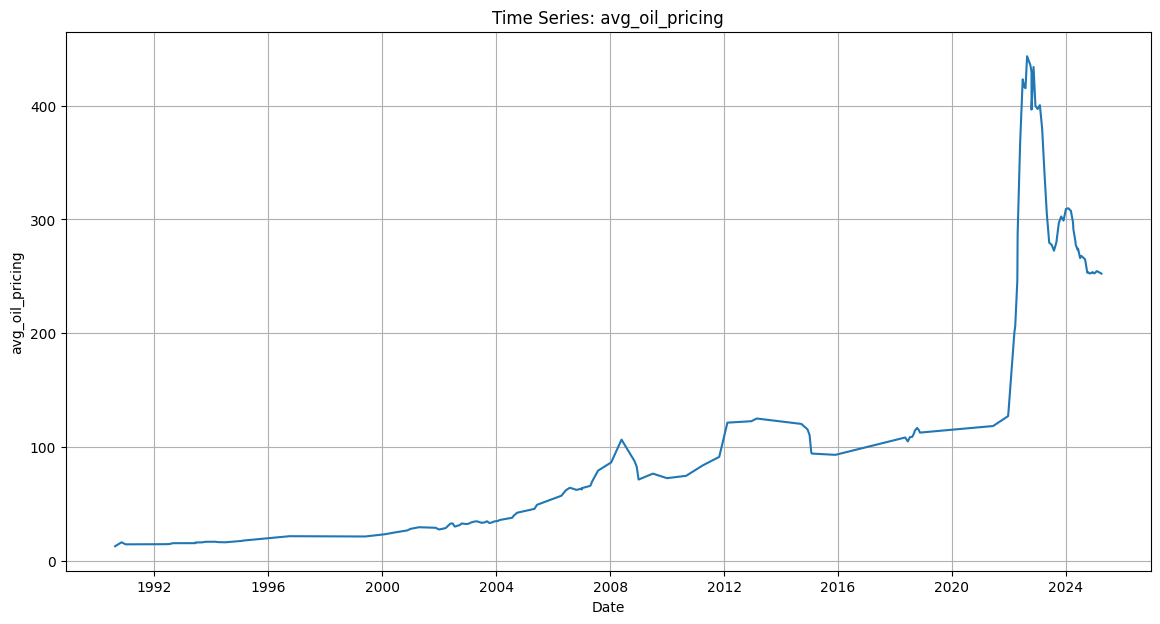

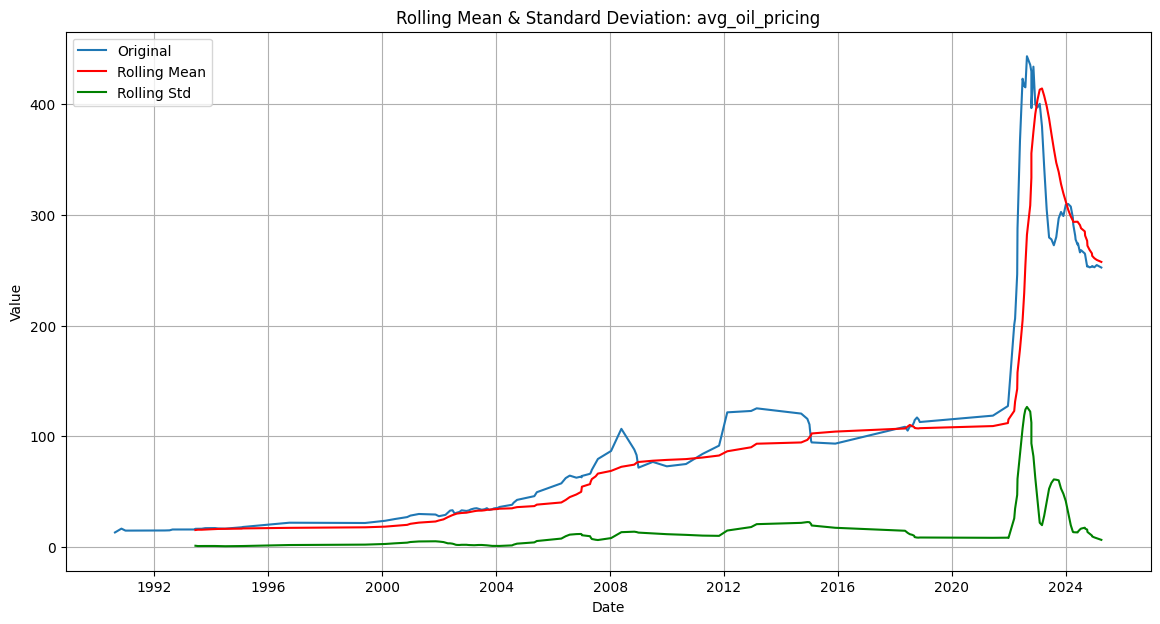

In [41]:
def visualize_time_series(data, column_name):
    plt.figure(figsize=(14, 7))

    plt.plot(data[column_name])
    plt.title(f'Time Series: {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.grid(True)
    plt.show()

    # plot rolling mean and standard deviation
    rolling_mean = data[column_name].rolling(window=12).mean()
    rolling_std = data[column_name].rolling(window=12).std()
    plt.figure(figsize=(14, 7))
    plt.plot(data[column_name], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.title(f'Rolling Mean & Standard Deviation: {column_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_time_series(average_oil_pricing_df, ts_column)

### Handle missing values and outliers within the Time Series

- **Forward fill**: refers to a method of imputation where values are replaced with the previous valid value in the dataset. This is also called as LOCF (Last Observation Carried Forward) <br><br>
- **Backward fill**: operates by replacing with the next valid value in the dataset (non missing value found in the dataset). <br><br>
- **Linear interpolation**: estimates missed values by assuming a liner relationship between data points: ```y = y1 + ((x - x1) / (x2 - x1)) * (y2 - y1)>``` <br><br>
- **Time-based interpolation**: estimates missed values by considering the temporal order of the data points. It leverages the relationship between data points at different time intervals to fill in the gaps, offering more accurate approach than simply using the mean or median

In [43]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Forward fill
    # data_ffill = data.fillna(method='ffill')
    
    # Backward fill
    # data_bfill = data.fillna(method='bfill')
    
    # Linear interpolation
    #  data_interp = data.interpolate(method='linear')
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

data_missing_values_handled = handle_missing_values(average_oil_pricing_df[ts_column])

Missing values before handling: 0
Missing values after handling: 0


- **Z-score Method**: The Z-score method detects outliers by measuring how many standard deviations a data point is away from the mean of the dataset. Data points with z-scores beyond a certain threshold (typically +3 to -3) are considered outliers <br><br>

In [71]:
def handle_outliers(data, column_name, threshold=3):
    data_clean = data.copy()
    
    z_scores = stats.zscore(data_clean[column_name])
    outliers = np.where(np.abs(z_scores) > threshold)
    print(f"Outliers dectected before handling: {len(outliers[0])}")
    if len(outliers[0]) > 0:
        outlier_dates = data_clean.index[outliers]
        rolling_median = data_clean[column_name].rolling(window=5, center=True, min_periods=1).median()
        rolling_median = rolling_median.fillna(data_clean[column_name].median())
        data_clean.loc[outlier_dates, column_name] = rolling_median.loc[outlier_dates]
    z_scores = stats.zscore(data_clean[column_name])
    outliers = np.where(np.abs(z_scores) > threshold)
    print(f"Outliers detected after handling: {len(outliers[0])}")
    return data_clean

data_cleaned = handle_outliers(average_oil_pricing_df, ts_column)

Outliers dectected before handling: 0
Outliers detected after handling: 0


=== OUTLIER HANDLING ===
Original data shape: (149, 2)
Original data statistics:
count    149.000000
mean     135.766086
std      129.218636
min       12.956250
25%       32.400000
50%       79.362500
75%      253.888889
max      443.444444
Name: avg_oil_pricing, dtype: float64
Outliers detected before handling: 11
Outlier indices: [Timestamp('2022-06-26 00:00:00'), Timestamp('2022-07-17 00:00:00'), Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-10-02 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-11-12 00:00:00'), Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-03 00:00:00'), Timestamp('2023-02-01 00:00:00')]
Outlier values: [423.11111111 416.44444444 415.33333333 443.44444444 435.66666667
 429.55555556 396.55555556 429.55555556 396.55555556 434.
 399.88888889 397.11111111 400.44444444]
Outliers detected after handling: 11
Remaining outlier indices: [Timestamp('2022-06-26 00:00:00'), Timestamp('

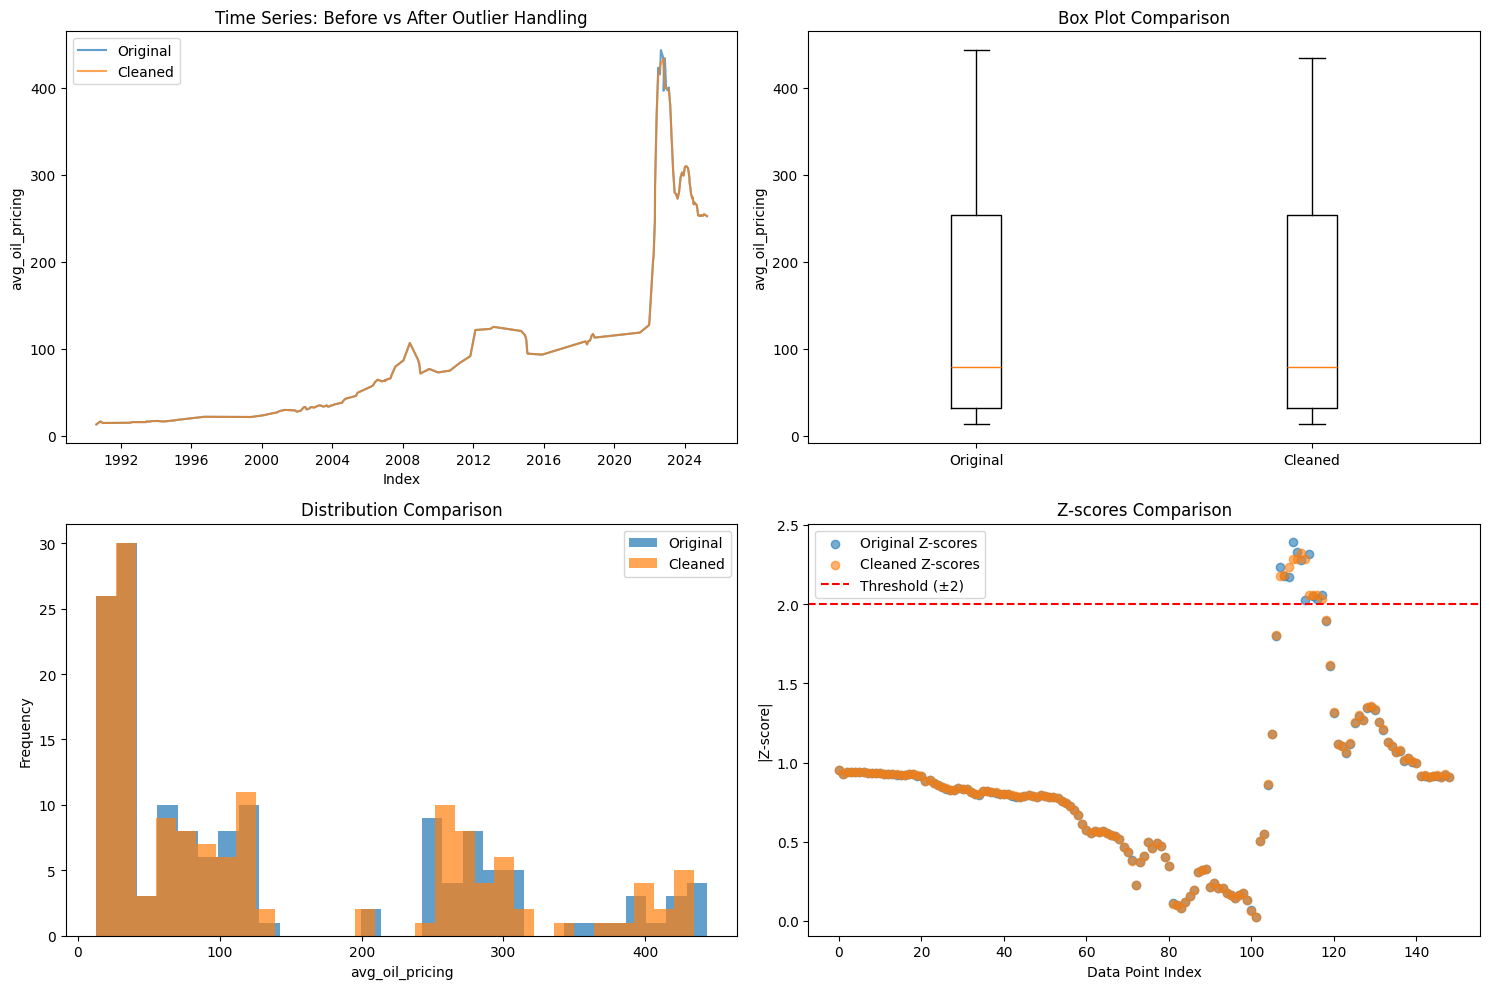

In [75]:
def handle_outliers(data, column_name, threshold=2, method='rolling_median'):
    data_clean = data.copy()
    
    original_data = data_clean[column_name].dropna()
    
    if len(original_data) == 0:
        print("No valid data points found!")
        return data_clean
    
    z_scores = np.abs(stats.zscore(original_data))
    outlier_mask = z_scores > threshold
    outlier_indices = original_data.index[outlier_mask]
    
    print(f"Outliers detected before handling: {len(outlier_indices)}")
    
    if len(outlier_indices) > 0:
        print(f"Outlier indices: {outlier_indices.tolist()}")
        print(f"Outlier values: {data_clean.loc[outlier_indices, column_name].values}")
        
        if method == 'rolling_median':
            rolling_median = data_clean[column_name].rolling(window=5, center=True, min_periods=1).median()
            rolling_median = rolling_median.fillna(data_clean[column_name].median())
            data_clean.loc[outlier_indices, column_name] = rolling_median.loc[outlier_indices]
            
        elif method == 'interpolation':
            temp_series = data_clean[column_name].copy()
            temp_series.loc[outlier_indices] = np.nan
            data_clean[column_name] = temp_series.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
            
        elif method == 'mean':
            rolling_mean = data_clean[column_name].rolling(window=5, center=True, min_periods=1).mean()
            rolling_mean = rolling_mean.fillna(data_clean[column_name].mean())
            data_clean.loc[outlier_indices, column_name] = rolling_mean.loc[outlier_indices]
            
        elif method == 'median':
            data_clean.loc[outlier_indices, column_name] = data_clean[column_name].median()
            
        elif method == 'clip':
            lower_bound = original_data.mean() - threshold * original_data.std()
            upper_bound = original_data.mean() + threshold * original_data.std()
            data_clean[column_name] = data_clean[column_name].clip(lower=lower_bound, upper=upper_bound)
    
    cleaned_data = data_clean[column_name].dropna()
    if len(cleaned_data) > 0:
        z_scores_after = np.abs(stats.zscore(cleaned_data))
        outliers_after = cleaned_data.index[z_scores_after > threshold]
        print(f"Outliers detected after handling: {len(outliers_after)}")
        
        if len(outliers_after) > 0:
            print(f"Remaining outlier indices: {outliers_after.tolist()}")
            print(f"Remaining outlier values: {data_clean.loc[outliers_after, column_name].values}")
    return data_clean

def compare_outlier_methods(data, column_name, threshold=2):
    methods = ['rolling_median', 'interpolation', 'mean', 'median', 'clip']
    results = {}
    
    print("=== COMPARING OUTLIER HANDLING METHODS ===\n")
    
    for method in methods:
        print(f"--- Method: {method.upper()} ---")
        cleaned_data = handle_outliers(data, column_name, threshold, method)
        
        original_std = data[column_name].std()
        cleaned_std = cleaned_data[column_name].std()
        
        results[method] = {
            'data': cleaned_data,
            'std_reduction': ((original_std - cleaned_std) / original_std) * 100,
            'mean_change': abs(data[column_name].mean() - cleaned_data[column_name].mean())
        }
        
        print(f"Standard deviation reduction: {results[method]['std_reduction']:.2f}%")
        print(f"Mean change: {results[method]['mean_change']:.4f}\n")
    
    return results

def visualize_outlier_handling(original_data, cleaned_data, column_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time series plot
    axes[0, 0].plot(original_data.index, original_data[column_name], label='Original', alpha=0.7)
    axes[0, 0].plot(cleaned_data.index, cleaned_data[column_name], label='Cleaned', alpha=0.7)
    axes[0, 0].set_title('Time Series: Before vs After Outlier Handling')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Index')
    axes[0, 0].set_ylabel(column_name)
    
    # Box plots
    box_data = [original_data[column_name].dropna(), cleaned_data[column_name].dropna()]
    axes[0, 1].boxplot(box_data, labels=['Original', 'Cleaned'])
    axes[0, 1].set_title('Box Plot Comparison')
    axes[0, 1].set_ylabel(column_name)
    
    # Histograms
    axes[1, 0].hist(original_data[column_name].dropna(), alpha=0.7, label='Original', bins=30)
    axes[1, 0].hist(cleaned_data[column_name].dropna(), alpha=0.7, label='Cleaned', bins=30)
    axes[1, 0].set_title('Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel(column_name)
    axes[1, 0].set_ylabel('Frequency')
    
    # Z-score comparison
    z_original = np.abs(stats.zscore(original_data[column_name].dropna()))
    z_cleaned = np.abs(stats.zscore(cleaned_data[column_name].dropna()))
    
    axes[1, 1].scatter(range(len(z_original)), z_original, alpha=0.6, label='Original Z-scores')
    axes[1, 1].scatter(range(len(z_cleaned)), z_cleaned, alpha=0.6, label='Cleaned Z-scores')
    axes[1, 1].axhline(y=2, color='r', linestyle='--', label='Threshold (±2)')
    axes[1, 1].set_title('Z-scores Comparison')
    axes[1, 1].legend()
    axes[1, 1].set_xlabel('Data Point Index')
    axes[1, 1].set_ylabel('|Z-score|')
    
    plt.tight_layout()
    plt.show()

def outlier_handling(df, ts_column, threshold=2):
    print("=== OUTLIER HANDLING ===")
    print(f"Original data shape: {df.shape}")
    print(f"Original data statistics:")
    print(df[ts_column].describe())
    
    df_cleaned = handle_outliers(df, ts_column, threshold=threshold, method='rolling_median')
    
    print(f"\nCleaned data statistics:")
    print(df_cleaned[ts_column].describe())
    
    visualize_outlier_handling(df, df_cleaned, ts_column)
    return df, df_cleaned

original_df, cleaned_df = outlier_handling(average_oil_pricing_df, ts_column)

In [77]:
ts = cleaned_df.loc[:, ts_column]
ts.head()

date
1990-08-14    12.95625
1990-11-05    16.41000
1990-12-26    14.63125
1991-01-01    14.61875
1992-05-13    14.74375
Name: avg_oil_pricing, dtype: float64

### Stationary analysis of the Time Series
- ARIMA Hypothesis: provided time series is stationary where the time series has constant mean, variance, and autocovariance over time
- Dickey Fuller Test: evaluates whether the time series has a unit root, which implies the series is not stationary

In [78]:
def check_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("\nThe series is stationary (reject H0)")
    else:
        print("\nThe series is non-stationary (fail to reject H0)")

In [79]:
check_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.479066
p-value                          0.543840
#Lags Used                       2.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
dtype: float64
Test Statistic                  -1.479066
p-value                          0.543840
#Lags Used                       2.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
dtype: float64
Test Statistic                  -1.479066
p-value                          0.543840
#Lags Used                       2.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64

The series is non-stationary (fail to reject H0)


In [80]:
def make_stationary(timeseries, seasonal_diff=None | int):
   # 1. Log transformation (reduces variance, handles exponential growth)
    if (timeseries > 0).all(): 
        ts_log = np.log(timeseries)
        plt.figure(figsize=(14, 5))
        plt.plot(ts_log, label='Log Transformed')
        plt.title('Log Transformation')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        ts_log = timeseries
        print("Skipping log transformation as data contains zero or negative values")

    # 2. Differencing (removes trend)
    ts_diff = ts_log.diff().dropna()
    plt.figure(figsize=(14, 5))
    plt.plot(ts_diff, label='Differenced')
    plt.title('Differenced Series (First Order)')
    plt.legend()
    plt.grid(True)
    plt.show()

    if seasonal_diff:
        # 3. Seasonal differencing (if applicable)
        # Example with 12 for monthly seasonality
        if len(ts_log) > 24: # Ensure enough data points
            ts_seasonal_diff = ts_log.diff(seasonal_diff).dropna()
            plt.figure(figsize=(14, 5))
            plt.plot(ts_seasonal_diff, label='Seasonally Differenced')
            plt.title(f'Seasonally Differenced Series (Difference: {seasonal_diff})')
            plt.legend()
            plt.grid(True)
            plt.show()
    # Check stationarity of transformed series
    print("\nStationarity check after first differencing:")
    check_stationarity(ts_diff)
    return ts_diff, ts_seasonal_diff

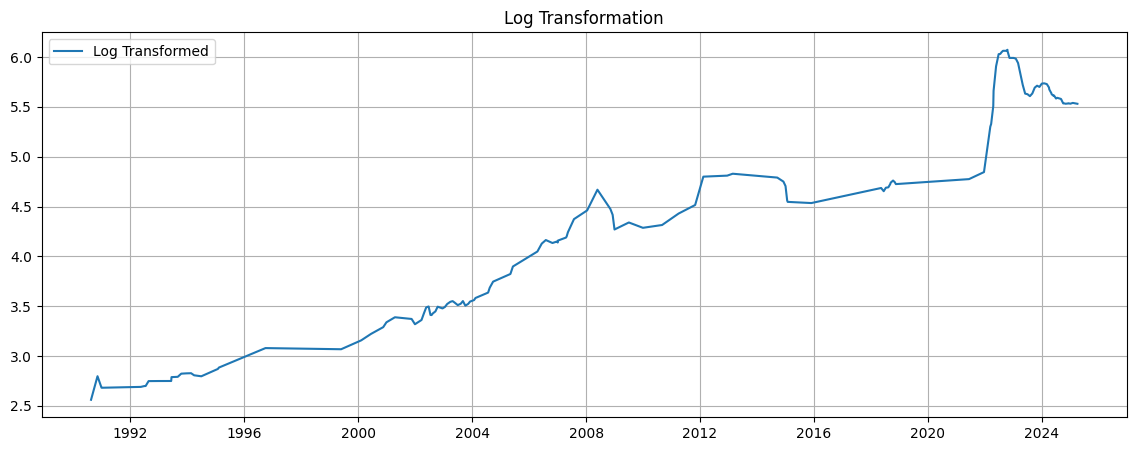

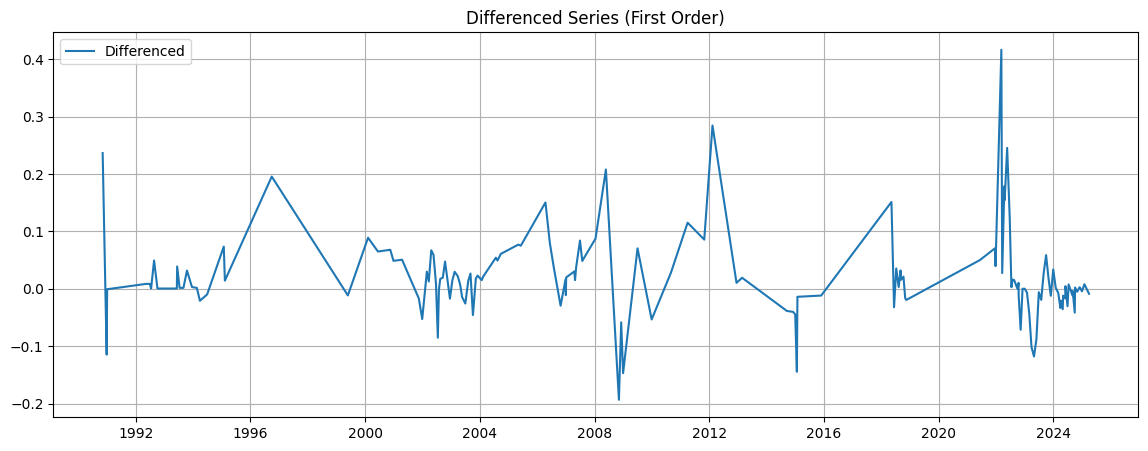

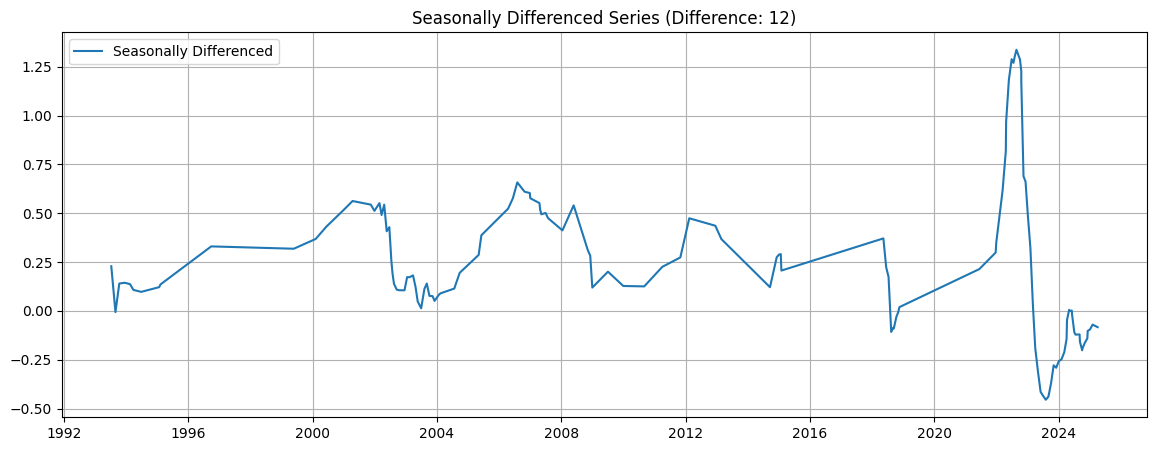


Stationarity check after first differencing:
Results of Dickey-Fuller Test:
Test Statistic                  -3.933805
p-value                          0.001800
#Lags Used                      14.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
dtype: float64
Test Statistic                  -3.933805
p-value                          0.001800
#Lags Used                      14.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
dtype: float64
Test Statistic                  -3.933805
p-value                          0.001800
#Lags Used                      14.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64

The series is stationary (reject H0)


In [83]:
result = make_stationary(ts, seasonal_diff=12)
ts_diff, ts_seasonal_diff = result[0], result[1]

In [85]:
np.save(os.path.join(preprocessed_data_dir_path, 'pricing_diff.npy'), ts_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'pricing_seasonal_diff.npy'), ts_seasonal_diff)

In [89]:
average_oil_pricing_df.to_csv(os.path.join(preprocessed_data_dir_path, 'avg_oil_pricing.csv'), index=False, encoding='utf-8')